In [1]:
#%matplotlib ipympl

In [2]:
from neuron import h, gui 
import os, pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from plots import plot_cell, plot_synaptic_connections, plot_cell_with_electrode, plot_bc_rgc, plot_electrode_z_view, plot_electric_field_slices
import random

from BC_model_template import ONBipolarCell
from helperFuns import move_rgc_along_z
from Stimulation import Stimulus
from matplotlib.lines import Line2D

--No graphics will be displayed.


In [3]:
# Load compiled channel mechanisms 
h.nrn_load_dll("/Users/lillikiessling/Documents/Stanford/Code/BC_model/Ion_channels/arm64/libnrnmech.dylib")

# Load standard run system 
h.load_file("nrngui.hoc")
h.load_file('stdrun.hoc') 

# Load RGC and BC models
h.load_file("RGC_model_Anna/RGC_20171004_S1W3C3_ON_S_150um_dend_low_14um_diameter_3um_axon_up_6um_axon_sections_20_axon_points_3000_axon_diam_1um.hoc")
h.load_file("nrn/cells/BC_Euler9_ON.hoc")

# Load the HOC files for Electric Field
FIELD_DIR = "/Users/lillikiessling/Documents/Stanford/Code/BC_model/Attach_Electric_Fields"
os.chdir(FIELD_DIR)
h.load_file('global.hoc')
h.load_file('interpxyz.hoc')
h.load_file('stimHexMono_biphasic.hoc')
print("Electric field mechanisms loaded")

INFO: Changes to geometry or nseg should be followed by setpointers()
Electric field mechanisms loaded


#### Define Hyperparameters

In [4]:
# --- Convergence knobs ---
N_BC = 10                  # number of bipolar cells converging onto 1 RGC  
N_RIBBONS_TOTAL = 160               # total number of ribbon synapses onto RGC

# --- Synapse params ---
NumSites = 10
GMAX  = 0.00256 
GMAXN = 0.00011 
MG    = 0.5

# -- Stimulus params ---
STIM_DELAY = 50 
STIM_DUR = 1
AMPLITUDE = 40

### 1. BC Cells

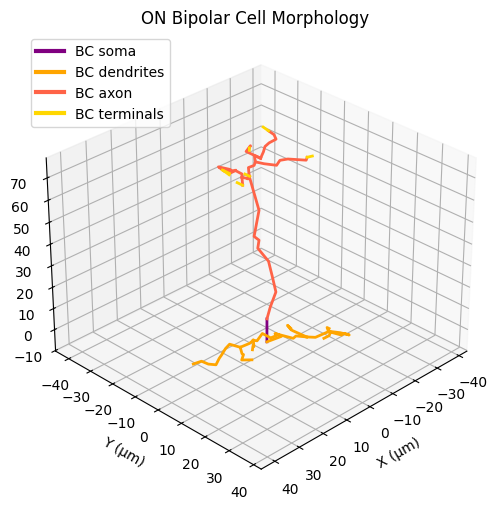

In [5]:
bc_cells = [ONBipolarCell() for _ in range(N_BC)]

preSyn_list = []
for bc in bc_cells:
    term_list = list(bc.terminal)
    preSyn = term_list[0]          # same convention as before
    preSyn_list.append(preSyn)

    # (optional) set Ca only where you did before
    for sec in bc.terminal:
        sec.cao = 1.8 
        sec.cai = 0.0001 
    for sec in bc.soma:
        sec.cao = 1.8 
        sec.cai = 0.0001 

plot_cell(bc_cells[0])

for bc in bc_cells:
    preSyn = list(bc.terminal)[0]
    preSyn.gcabar_Bip_CaL =  150 / 1000 

### 2. RGC Cell

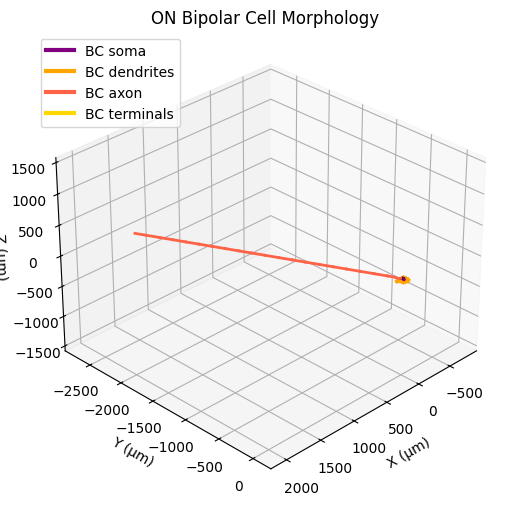

In [6]:
class RGCWrapper:
    pass

rgc_cell = RGCWrapper()
rgc_cell.soma = h.soma
rgc_cell.dend = h.dend
rgc_cell.axon = h.axon
rgc_cell.hill = h.hill
rgc_cell.AISP = h.AISP
rgc_cell.AISD = h.AISD

# optional: mimic your template's SectionLists if your plotting needs them
rgc_cell.all = h.SectionList()
for i in range(74):
    rgc_cell.all.append(sec=h.dend[i])
rgc_cell.all.append(sec=h.hill)
rgc_cell.all.append(sec=h.AISP)
rgc_cell.all.append(sec=h.AISD)
for i in range(20):
    rgc_cell.all.append(sec=h.axon[i])
rgc_cell.all.append(sec=h.soma)

h.define_shape()

plot_cell(rgc_cell)

### 3. Insert XTRA Mechanisms

In [7]:
def insert_xtra_mechanisms(cell_list):
    """Insert extracellular and xtra mechanisms into all sections."""
    for cell in cell_list:
        for sec in cell.all:
            sec.insert('extracellular')
            sec.insert('xtra')
    print(f"Inserted xtra into {len(cell_list)} cells")

# Insert into BC cells
insert_xtra_mechanisms(bc_cells)

# Insert into RGC
for sec in rgc_cell.all:
    sec.insert('extracellular')
    sec.insert('xtra')
print("Inserted xtra into RGC")

Inserted xtra into 10 cells
Inserted xtra into RGC


In [8]:
def connect_extracellular_pointers():
    """Connect xtra mechanism pointers to extracellular mechanism."""
    from neuron import h
    
    # For BC cells
    for bc in bc_cells:
        for sec in bc.all:
            if hasattr(sec(0.5), 'xtra'):
                for seg in sec:
                    h.setpointer(seg._ref_e_extracellular, 'ex', seg.xtra)
                    h.setpointer(seg._ref_i_membrane, 'im', seg.xtra)
    
    # For RGC
    for sec in rgc_cell.all:
        if hasattr(sec(0.5), 'xtra'):
            for seg in sec:
                h.setpointer(seg._ref_e_extracellular, 'ex', seg.xtra)
                h.setpointer(seg._ref_i_membrane, 'im', seg.xtra)
    
    print("Connected extracellular pointers")

# Call this AFTER inserting xtra mechanisms but BEFORE h.setpointers()
connect_extracellular_pointers()

Connected extracellular pointers


### 4. Alignment of cells

BC 0: positioned at (30.0, 0.0, 15.0)
BC 1: positioned at (24.3, 17.6, 15.0)
BC 2: positioned at (9.3, 28.5, 15.0)
BC 3: positioned at (-9.3, 28.5, 15.0)
BC 4: positioned at (-24.3, 17.6, 15.0)
BC 5: positioned at (-30.0, 0.0, 15.0)
BC 6: positioned at (-24.3, -17.6, 15.0)
BC 7: positioned at (-9.3, -28.5, 15.0)
BC 8: positioned at (9.3, -28.5, 15.0)
BC 9: positioned at (24.3, -17.6, 15.0)
Loading electric field data for X-Z visualization...


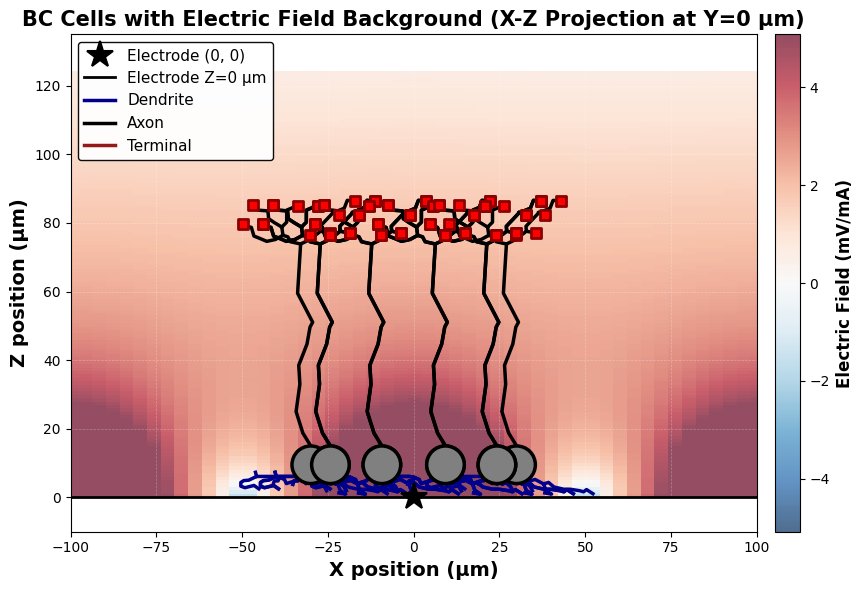

In [9]:
ELECTRODE_X = h.ImplantX
ELECTRODE_Y = h.ImplantY
ELECTRODE_Z = h.ImplantZ
BC_SPREAD_RADIUS = 30  # um, spread of BCs around electrode in x-y plane
offset_z = 15

for i, bc in enumerate(bc_cells):
    # Circular arrangement in x-y plane
    angle = 2 * np.pi * i / N_BC
    offset_x = BC_SPREAD_RADIUS * np.cos(angle)
    offset_y = BC_SPREAD_RADIUS * np.sin(angle)
    
    # Target position
    target_x = ELECTRODE_X + offset_x
    target_y = ELECTRODE_Y + offset_y
    target_z = ELECTRODE_Z + offset_z
    
    # Get current BC soma position
    current_x = h.x3d(0, sec=bc.soma)
    current_y = h.y3d(0, sec=bc.soma)
    current_z = h.z3d(0, sec=bc.soma)
    
    # Calculate translation needed
    dx = target_x - current_x
    dy = target_y - current_y
    dz = target_z - current_z
    
    # Move entire cell
    for sec in bc.all:
        n_pts = int(h.n3d(sec=sec))
        for j in range(n_pts):
            x_old = h.x3d(j, sec=sec)
            y_old = h.y3d(j, sec=sec)
            z_old = h.z3d(j, sec=sec)
            diam = h.diam3d(j, sec=sec)
            
            h.pt3dchange(j, 
                        x_old + dx,
                        y_old + dy, 
                        z_old + dz,
                        diam, sec=sec)
    
    print(f"BC {i}: positioned at ({target_x:.1f}, {target_y:.1f}, {target_z:.1f})")

plot_electrode_z_view(bc_cells=bc_cells, field_files_dir=f'{FIELD_DIR}/seq01_Spot1200_2Hz')

In [10]:
def position_rgc_above_bcs(rgc_cell, bc_cells, spacing_bc_rgc=10):

    # 1. Find average BC terminal position
    bc_terminal_positions = []
    for bc in bc_cells:
        term = list(bc.terminal)[0]
        n = int(h.n3d(sec=term))
        if n > 0:
            # Get terminal endpoint (where it contacts RGC)
            term_x = h.x3d(n-1, sec=term)
            term_y = h.y3d(n-1, sec=term)
            term_z = h.z3d(n-1, sec=term)
            bc_terminal_positions.append((term_x, term_y, term_z))
    
    # Average position of all BC terminals
    avg_bc_term_x = np.mean([p[0] for p in bc_terminal_positions])
    avg_bc_term_y = np.mean([p[1] for p in bc_terminal_positions])
    avg_bc_term_z = np.mean([p[2] for p in bc_terminal_positions])
    
    print(f"\nAverage BC terminal position: ({avg_bc_term_x:.1f}, {avg_bc_term_y:.1f}, {avg_bc_term_z:.1f})")
    
    # 2. Find RGC's current dendritic field extent
    rgc_dend_z_coords = []
    for sec in rgc_cell.all:
        if 'dend' in sec.name():
            n = int(h.n3d(sec=sec))
            for i in range(n):
                rgc_dend_z_coords.append(h.z3d(i, sec=sec))
    
    if len(rgc_dend_z_coords) > 0:
        rgc_dend_z_min = min(rgc_dend_z_coords)
        rgc_dend_z_max = max(rgc_dend_z_coords)
        print(f"RGC dendrites currently span Z: {rgc_dend_z_min:.1f} to {rgc_dend_z_max:.1f}")
    
    # 3. Get current RGC soma position
    current_soma_x = h.x3d(0, sec=rgc_cell.soma)
    current_soma_y = h.y3d(0, sec=rgc_cell.soma)
    current_soma_z = h.z3d(0, sec=rgc_cell.soma)
    
    print(f"RGC soma currently at: ({current_soma_x:.1f}, {current_soma_y:.1f}, {current_soma_z:.1f})")
    
    # 4. Calculate target RGC soma position using spacing parameter
    target_rgc_soma_x = avg_bc_term_x  # Center on BC terminal cloud
    target_rgc_soma_y = avg_bc_term_y
    target_rgc_soma_z = avg_bc_term_z + spacing_bc_rgc
    
    print(f"\nUsing BC-RGC spacing: {spacing_bc_rgc} μm")
    
    # 5. Calculate translation
    dx = target_rgc_soma_x - current_soma_x
    dy = target_rgc_soma_y - current_soma_y
    dz = target_rgc_soma_z - current_soma_z
    
    print(f"Translation needed: dx={dx:.1f}, dy={dy:.1f}, dz={dz:.1f}")
    
    # 6. Move entire RGC
    for sec in rgc_cell.all:
        n_pts = int(h.n3d(sec=sec))
        for j in range(n_pts):
            x_old = h.x3d(j, sec=sec)
            y_old = h.y3d(j, sec=sec)
            z_old = h.z3d(j, sec=sec)
            diam = h.diam3d(j, sec=sec)
            
            h.pt3dchange(j, 
                        x_old + dx,
                        y_old + dy, 
                        z_old + dz,
                        diam, sec=sec)
    
    # 7. Verify final position
    new_soma_x = h.x3d(0, sec=rgc_cell.soma)
    new_soma_y = h.y3d(0, sec=rgc_cell.soma)
    new_soma_z = h.z3d(0, sec=rgc_cell.soma)
    
    print(f"\n✓ RGC soma repositioned to: ({new_soma_x:.1f}, {new_soma_y:.1f}, {new_soma_z:.1f})")
    
    # 8. Check if within field bounds
    in_bounds_xy = (-1000 <= new_soma_x <= 1000 and -1000 <= new_soma_y <= 1000)
    in_bounds_z = (0 <= new_soma_z <= 124)
    
    if in_bounds_xy and in_bounds_z:
        print("✓ RGC is within electric field bounds")
    else:
        print(f"⚠ WARNING: RGC may be outside field bounds!")
        print(f"  XY in bounds: {in_bounds_xy}, Z in bounds: {in_bounds_z}")
        if not in_bounds_z:
            print(f"  Z = {new_soma_z:.1f} is outside [0, 124] μm")
            if new_soma_z < 0:
                print(f"  → Try reducing spacing_bc_rgc (currently {spacing_bc_rgc})")
            else:
                print(f"  → BC terminals at z={avg_bc_term_z:.1f} + spacing {spacing_bc_rgc} = {new_soma_z:.1f}")
    
    # 9. Report synaptic contact zone
    print(f"\nSynaptic contact zone:")
    print(f"  BC terminals:   z ≈ {avg_bc_term_z:.1f} μm")
    print(f"  RGC soma:       z = {new_soma_z:.1f} μm")
    print(f"  RGC dendrites:  z = {rgc_dend_z_min:.1f} to {rgc_dend_z_max:.1f} μm")
    
    # Check overlap
    if rgc_dend_z_coords:
        new_rgc_dend_z_min = min(rgc_dend_z_coords) + dz
        new_rgc_dend_z_max = max(rgc_dend_z_coords) + dz
        
        if new_rgc_dend_z_min <= avg_bc_term_z <= new_rgc_dend_z_max:
            print("  ✓ BC terminals within RGC dendritic field")
        else:
            print(f"  ⚠ BC terminals may be outside RGC dendritic field!")
            print(f"    Adjusted to: z = {new_rgc_dend_z_min:.1f} to {new_rgc_dend_z_max:.1f}")
    
    return target_rgc_soma_x, target_rgc_soma_y, target_rgc_soma_z


rgc_target_pos = position_rgc_above_bcs(rgc_cell, bc_cells, spacing_bc_rgc=20)


Average BC terminal position: (-19.6, -0.4, 79.6)
RGC dendrites currently span Z: -18.4 to 0.0
RGC soma currently at: (0.0, 0.0, -9.5)

Using BC-RGC spacing: 20 μm
Translation needed: dx=-19.6, dy=-0.4, dz=109.1

✓ RGC soma repositioned to: (-19.6, -0.4, 99.6)
✓ RGC is within electric field bounds

Synaptic contact zone:
  BC terminals:   z ≈ 79.6 μm
  RGC soma:       z = 99.6 μm
  RGC dendrites:  z = -18.4 to 0.0 μm
  ⚠ BC terminals may be outside RGC dendritic field!
    Adjusted to: z = 90.7 to 109.1


Loading electric field data for X-Z visualization...


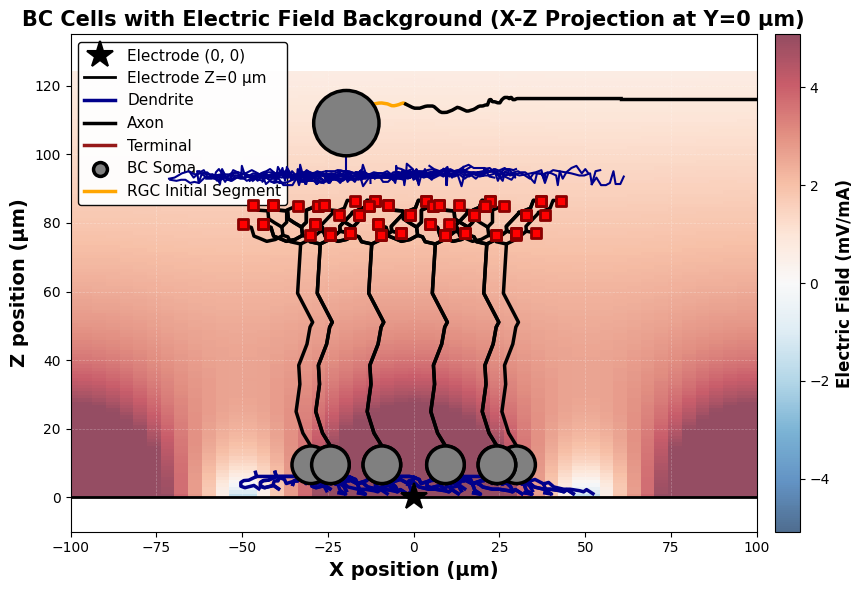

In [11]:
plot_electrode_z_view(bc_cells=bc_cells, rgc_cell=rgc_cell, field_files_dir=f'{FIELD_DIR}/seq01_Spot1200_2Hz')

### 5. Attach electric field

In [12]:
### 5. Attach electric field - MANUAL ASSIGNMENT

# Set stimulus parameters
h.hexDel = STIM_DELAY
h.hexDur = STIM_DUR
h.hexAmp = AMPLITUDE

# Initialize coordinates
h.ATTACHED__ = 0
h.setpointers()  # Compute xyz coords

# BYPASS HOC's setrx() - manually assign field values
print("\n" + "="*80)
print("LOADING ELECTRIC FIELD DATA")
print("="*80)

# Load all field slices into memory
field_slices = []
for i in range(125):
    with open(f'{FIELD_DIR}/seq01_Spot1200_2Hz/slice_{i}.txt', 'r') as f:
        field_data = pd.read_csv(f, sep='\t', header=None).values
    field_slices.append(field_data)
print(f"✓ Loaded {len(field_slices)} field slices")

# Manually assign field to every segment
def assign_field(cell_list):
    """Manually assign RPSim_Ex_xtra to all segments."""
    segment_count = 0
    assigned_count = 0
    
    for cell in cell_list:
        for sec in cell.all:
            for seg in sec:
                segment_count += 1
                
                # Get position
                x = seg.x_xtra
                y = seg.y_xtra
                z = seg.z_xtra
                
                # Calculate indices
                slice_idx = int((z - h.ImplantZ) / h.z_spacing)
                rel_x = int((x - (-1000 + h.ImplantX)) / h.x_spacing)
                rel_y = int((y - (-1000 + h.ImplantY)) / h.y_spacing)
                
                # Check bounds and assign
                if 0 <= slice_idx < 125 and 0 <= rel_x < 501 and 0 <= rel_y < 501:
                    field_value = field_slices[slice_idx][rel_y, rel_x]
                    seg.RPSim_Ex_xtra = field_value
                    assigned_count += 1
    
    return segment_count, assigned_count

# Assign to BC cells
bc_total, bc_assigned = assign_field(bc_cells)
print(f"BC cells: {bc_assigned}/{bc_total} segments assigned")

# Assign to RGC
rgc_total, rgc_assigned = assign_field([rgc_cell])
print(f"RGC cell: {rgc_assigned}/{rgc_total} segments assigned")

# Set up stimulus waveform
h.setStim()


LOADING ELECTRIC FIELD DATA
✓ Loaded 125 field slices
BC cells: 1700/1700 segments assigned
RGC cell: 697/1084 segments assigned


0.0

In [13]:
# Verify
bc = bc_cells[0]
term = list(bc.terminal)[0]
print(f"\nVerification:")
print(f"  BC 0 Terminal RPSim_Ex: {term(0.5).RPSim_Ex_xtra:.6f} mV/mA")
print(f"  Expected ~1.7 mV/mA for z≈84 μm")

if term(0.5).RPSim_Ex_xtra > 0:
    print("Electric field loaded successfully")
else:
    print("Field loading failed")
    
print("="*80 + "\n")


Verification:
  BC 0 Terminal RPSim_Ex: 1.871919 mV/mA
  Expected ~1.7 mV/mA for z≈84 μm
Electric field loaded successfully



### 6. Connect BC terminals and RGC dendrites via Ribbon Tiger Synapse

In [14]:
# I want int(N_RIBBONS_TOTAL / N_BC) presynaptic sites on the BC cell at random locations withing the BC cells terminal section to be connected to postsynaptic sites on the RGC dendrites at random locations in the range of the BC radius.

# syn = h.ribbon_tiger_simple(sec(0.5))
# h.setpointer(preSyn(0.5).ca_ion._ref_cai,  'preCA', syn)

In [15]:
### 6. Connect BC terminals and RGC dendrites via Ribbon Tiger Synapse (FIXED - BC-specific territories)

# Calculate ribbons per BC
ribbons_per_bc = int(N_RIBBONS_TOTAL / N_BC)
print(f"\n{'='*80}")
print(f"CREATING SYNAPTIC CONNECTIONS")
print(f"{'='*80}")
print(f"Total ribbons: {N_RIBBONS_TOTAL}")
print(f"Number of BCs: {N_BC}")
print(f"Ribbons per BC: {ribbons_per_bc}")

# First, check how many terminals each BC has
print(f"\nBC Terminal Counts:")
for bc_idx, bc in enumerate(bc_cells):
    n_terminals = len(list(bc.terminal))
    print(f"  BC {bc_idx}: {n_terminals} terminal sections")

print(f"{'='*80}\n")

# Storage for all synapses
synapses = []
synapse_locations = []  # For visualization

def get_random_terminal_location(bc):
    """Get random location on ANY of the BC's terminal sections."""
    # Get ALL terminal sections
    all_terminals = list(bc.terminal)
    
    if len(all_terminals) == 0:
        raise ValueError("BC has no terminal sections!")
    
    # Randomly choose one terminal section
    term_sec = random.choice(all_terminals)
    
    # Random position along the section (0 to 1)
    pos = random.uniform(0.1, 0.9)  # Avoid exact ends
    
    # Get 3D coordinates at this position
    n_pts = int(h.n3d(sec=term_sec))
    if n_pts == 0:
        # Fallback if no 3D points
        pos = 0.5
        h.define_shape()
        x = term_sec.x3d(0)
        y = term_sec.y3d(0)
        z = term_sec.z3d(0)
    else:
        idx = int(pos * (n_pts - 1))
        idx = max(0, min(idx, n_pts - 1))
        
        x = h.x3d(idx, sec=term_sec)
        y = h.y3d(idx, sec=term_sec)
        z = h.z3d(idx, sec=term_sec)
    
    return term_sec, pos, (x, y, z)

def get_bc_center_xy(bc):
    """Get the center (x, y) position of a BC based on its terminals."""
    all_terminals = list(bc.terminal)
    
    x_coords = []
    y_coords = []
    
    for term in all_terminals:
        n_pts = int(h.n3d(sec=term))
        if n_pts > 0:
            for i in range(n_pts):
                x_coords.append(h.x3d(i, sec=term))
                y_coords.append(h.y3d(i, sec=term))
    
    if len(x_coords) == 0:
        # Fallback to soma
        x_coords.append(h.x3d(0, sec=bc.soma))
        y_coords.append(h.y3d(0, sec=bc.soma))
    
    center_x = np.mean(x_coords)
    center_y = np.mean(y_coords)
    
    return center_x, center_y

def get_random_rgc_dendrite_location_near_bc(bc, bc_projection_radius=15):
    """
    Get random location on RGC dendrite within BC's projection radius.
    
    Parameters:
    -----------
    bc : BC cell object
        The specific BC that will connect to this dendrite
    bc_projection_radius : float
        Radius (in μm) around the BC's terminal center to search for RGC dendrites
    """
    # Get BC's center position
    bc_center_x, bc_center_y = get_bc_center_xy(bc)
    
    # Find all RGC dendritic segments within this BC's radius
    dend_segments = []
    for i in range(len(rgc_cell.dend)):
        sec = rgc_cell.dend[i]
        n_pts = int(h.n3d(sec=sec))
        
        for seg in sec:
            # Get segment coordinates
            seg_idx = int(seg.x * (n_pts - 1)) if n_pts > 1 else 0
            seg_idx = min(seg_idx, n_pts - 1)
            
            x = h.x3d(seg_idx, sec=sec)
            y = h.y3d(seg_idx, sec=sec)
            z = h.z3d(seg_idx, sec=sec)
            
            # Calculate distance from THIS BC's center in x-y plane
            dist_xy = np.sqrt((x - bc_center_x)**2 + (y - bc_center_y)**2)
            
            # Only include if within THIS BC's projection radius
            if dist_xy <= bc_projection_radius:
                dend_segments.append((sec, seg.x, (x, y, z)))
    
    if len(dend_segments) == 0:
        # Fallback: use closest dendrite segment to this BC
        print(f"  WARNING: No dendrites within {bc_projection_radius} μm of BC at ({bc_center_x:.1f}, {bc_center_y:.1f})")
        print(f"           Using closest dendrite segment instead")
        
        min_dist = float('inf')
        closest_seg = None
        
        for i in range(len(rgc_cell.dend)):
            sec = rgc_cell.dend[i]
            n_pts = int(h.n3d(sec=sec))
            
            for seg in sec:
                seg_idx = int(seg.x * (n_pts - 1)) if n_pts > 1 else 0
                seg_idx = min(seg_idx, n_pts - 1)
                
                x = h.x3d(seg_idx, sec=sec)
                y = h.y3d(seg_idx, sec=sec)
                z = h.z3d(seg_idx, sec=sec)
                
                dist = np.sqrt((x - bc_center_x)**2 + (y - bc_center_y)**2)
                
                if dist < min_dist:
                    min_dist = dist
                    closest_seg = (sec, seg.x, (x, y, z))
        
        if closest_seg is None:
            # Last resort
            sec = rgc_cell.dend[0]
            pos = 0.5
            n_pts = int(h.n3d(sec=sec))
            idx = n_pts // 2 if n_pts > 1 else 0
            x = h.x3d(idx, sec=sec)
            y = h.y3d(idx, sec=sec)
            z = h.z3d(idx, sec=sec)
            return sec, pos, (x, y, z)
        
        return closest_seg
    
    # Randomly choose one from available segments
    sec, pos, coords = random.choice(dend_segments)
    return sec, pos, coords

# Define BC projection radius (can be adjusted)
BC_PROJECTION_RADIUS = 20  # μm - each BC projects to RGC dendrites within this radius

print(f"BC projection radius: {BC_PROJECTION_RADIUS} μm\n")

# Create synapses for each BC
for bc_idx, bc in enumerate(bc_cells):
    all_terminals = list(bc.terminal)
    bc_center_x, bc_center_y = get_bc_center_xy(bc)
    
    print(f"BC {bc_idx} ({len(all_terminals)} terminals, center at ({bc_center_x:.1f}, {bc_center_y:.1f})):")
    
    # Track which terminals get synapses
    terminal_synapse_count = {term.name(): 0 for term in all_terminals}
    
    for ribbon_idx in range(ribbons_per_bc):
        # Get presynaptic location (BC terminal - randomly chosen from all terminals)
        pre_sec, pre_pos, pre_coords = get_random_terminal_location(bc)
        
        # Get postsynaptic location (RGC dendrite within THIS BC's radius)
        post_sec, post_pos, post_coords = get_random_rgc_dendrite_location_near_bc(
            bc, BC_PROJECTION_RADIUS
        )
        
        # Create ribbon synapse at postsynaptic location
        syn = h.ribbon_tiger_simple(post_sec(post_pos))
        
        # Set synapse parameters
        syn.gmax = GMAX
        syn.gmaxN = GMAXN
        
        # Connect presynaptic calcium to synapse
        h.setpointer(pre_sec(pre_pos).ca_ion._ref_cai, 'preCA', syn)
        
        # Store synapse
        synapses.append(syn)
        
        # Store locations for visualization
        synapse_locations.append({
            'bc_idx': bc_idx,
            'ribbon_idx': ribbon_idx,
            'bc_center': (bc_center_x, bc_center_y),
            'pre_sec': pre_sec.name(),
            'pre_pos': pre_pos,
            'pre_coords': pre_coords,
            'post_sec': post_sec.name(),
            'post_pos': post_pos,
            'post_coords': post_coords,
            'synapse': syn
        })
        
        # Track synapse distribution
        terminal_synapse_count[pre_sec.name()] += 1
    
    # Print distribution across terminals
    print(f"  Synapse distribution across terminals:")
    for term_name, count in terminal_synapse_count.items():
        print(f"    {term_name}: {count} synapses")
    print()

print(f"{'='*80}")
print(f"✓ Created {len(synapses)} synapses total")
print(f"  Expected: {N_BC * ribbons_per_bc}")
print(f"  Match: {'✓' if len(synapses) == N_BC * ribbons_per_bc else '✗'}")
print(f"{'='*80}\n")

# Verify connections
print("\nVERIFYING CONNECTIONS:")

# Count unique terminal sections used
unique_terminals = set([loc['pre_sec'] for loc in synapse_locations])
print(f"  Unique BC terminal sections with synapses: {len(unique_terminals)}")
print(f"  Total BC terminal sections: {sum([len(list(bc.terminal)) for bc in bc_cells])}")

# Verify BC-specific territories
print(f"\nVerifying BC-specific synaptic territories:")
for bc_idx in range(N_BC):
    bc_syns = [loc for loc in synapse_locations if loc['bc_idx'] == bc_idx]
    bc_center_x, bc_center_y = bc_syns[0]['bc_center']
    
    # Check postsynaptic distances from BC center
    distances = []
    for loc in bc_syns:
        post_x, post_y, post_z = loc['post_coords']
        dist_xy = np.sqrt((post_x - bc_center_x)**2 + (post_y - bc_center_y)**2)
        distances.append(dist_xy)
    
    print(f"  BC {bc_idx}: Post-synaptic distances from BC center: "
          f"mean={np.mean(distances):.1f}, max={np.max(distances):.1f} μm")

# Test one synapse
if len(synapses) > 0:
    test_syn = synapses[0]
    print(f"\nTest synapse parameters:")
    print(f"  gmax: {test_syn.gmax}")
    print(f"  gmaxN: {test_syn.gmaxN}")


CREATING SYNAPTIC CONNECTIONS
Total ribbons: 160
Number of BCs: 10
Ribbons per BC: 16

BC Terminal Counts:
  BC 0: 7 terminal sections
  BC 1: 7 terminal sections
  BC 2: 7 terminal sections
  BC 3: 7 terminal sections
  BC 4: 7 terminal sections
  BC 5: 7 terminal sections
  BC 6: 7 terminal sections
  BC 7: 7 terminal sections
  BC 8: 7 terminal sections
  BC 9: 7 terminal sections

BC projection radius: 20 μm

BC 0 (7 terminals, center at (28.1, -8.2)):
  Synapse distribution across terminals:
    BC_Euler9_ON[0].term[0]: 2 synapses
    BC_Euler9_ON[0].term[1]: 3 synapses
    BC_Euler9_ON[0].term[2]: 4 synapses
    BC_Euler9_ON[0].term[3]: 1 synapses
    BC_Euler9_ON[0].term[4]: 5 synapses
    BC_Euler9_ON[0].term[5]: 0 synapses
    BC_Euler9_ON[0].term[6]: 1 synapses

BC 1 (7 terminals, center at (22.3, 9.5)):
  Synapse distribution across terminals:
    BC_Euler9_ON[1].term[0]: 4 synapses
    BC_Euler9_ON[1].term[1]: 2 synapses
    BC_Euler9_ON[1].term[2]: 1 synapses
    BC_Euler

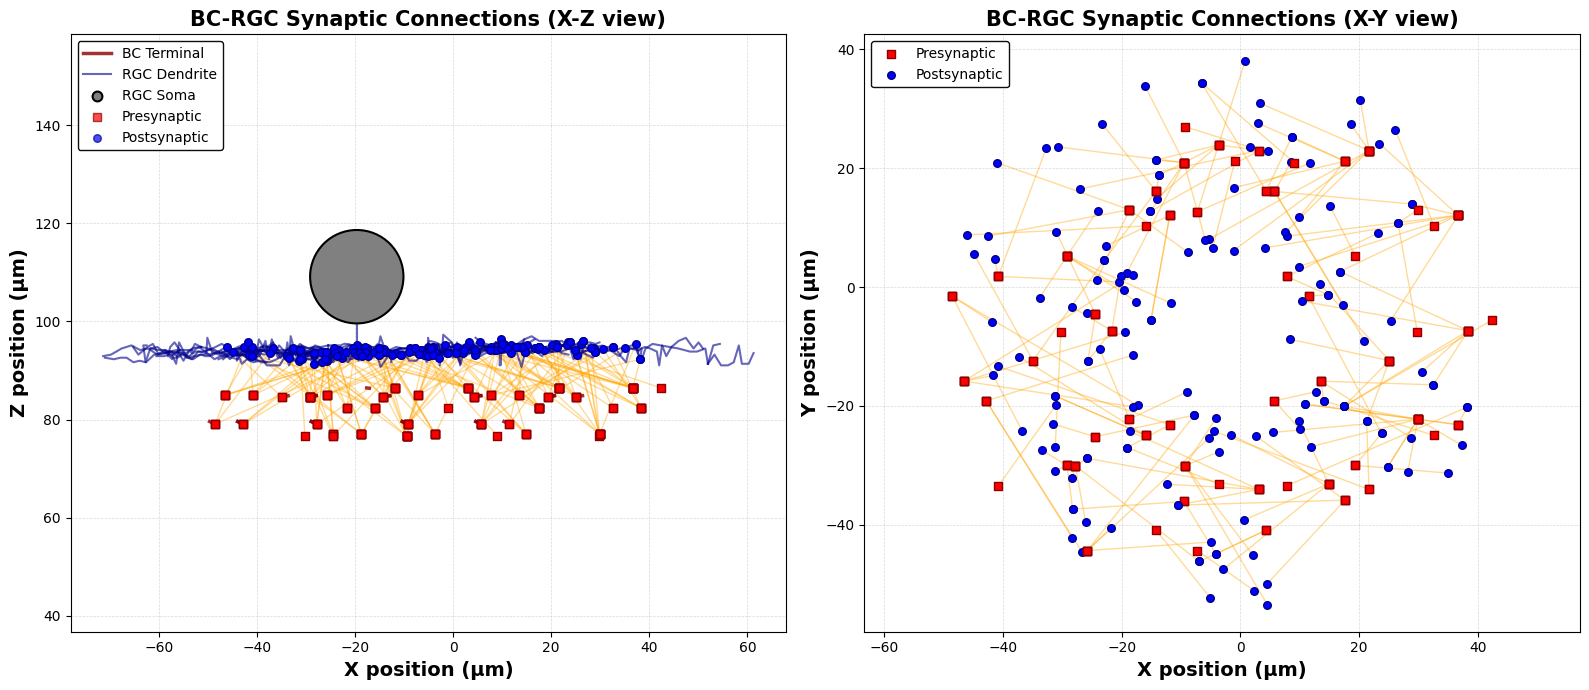

In [16]:
plot_synaptic_connections(bc_cells=bc_cells, rgc_cell=rgc_cell, synapse_locations=synapse_locations)

### 7. Extracellular Stimulation using simulated electric field of PRIMA device

##### Set up recording vectors

In [17]:
# TODO: Clean up check which ones I actually need

bc_cell_0 = bc_cells[0]
bc_cell_1 = bc_cells[1]

t_vec = h.Vector().record(h._ref_t)

# ============================================================================
# BC CELL 0 - Recording
# ============================================================================
term_0 = list(bc_cell_0.terminal)[0]
v_bc_pre_0 = h.Vector().record(term_0(0.5)._ref_v)
v_bc_soma_0 = h.Vector().record(bc_cell_0.soma(0.5)._ref_v)
ca_pre_0 = h.Vector().record(term_0(0.5)._ref_cai)
ica_bc_0 = h.Vector().record(term_0(0.5)._ref_ica)
ina_bc_0 = h.Vector().record(term_0(0.5)._ref_ina)

v_bc_dend_0 = {}
v_bc_axon_0 = {}
for sec in bc_cell_0.dendritic:
    vec = h.Vector()
    vec.record(sec(0.5)._ref_v)
    v_bc_dend_0[sec.name()] = vec
for sec in bc_cell_0.axonal:
    vec = h.Vector()
    vec.record(sec(0.5)._ref_v)
    v_bc_axon_0[sec.name()] = vec

d_0 = next(iter(bc_cell_0.dendritic))
ina_dend_0 = h.Vector().record(d_0(0.5)._ref_ina)

# ============================================================================
# BC CELL 1 - Recording
# ============================================================================
term_1 = list(bc_cell_1.terminal)[0]
v_bc_pre_1 = h.Vector().record(term_1(0.5)._ref_v)
v_bc_soma_1 = h.Vector().record(bc_cell_1.soma(0.5)._ref_v)
ca_pre_1 = h.Vector().record(term_1(0.5)._ref_cai)
ica_bc_1 = h.Vector().record(term_1(0.5)._ref_ica)
ina_bc_1 = h.Vector().record(term_1(0.5)._ref_ina)

v_bc_dend_1 = {}
v_bc_axon_1 = {}
for sec in bc_cell_1.dendritic:
    vec = h.Vector()
    vec.record(sec(0.5)._ref_v)
    v_bc_dend_1[sec.name()] = vec
for sec in bc_cell_1.axonal:
    vec = h.Vector()
    vec.record(sec(0.5)._ref_v)
    v_bc_axon_1[sec.name()] = vec

d_1 = next(iter(bc_cell_1.dendritic))
ina_dend_1 = h.Vector().record(d_1(0.5)._ref_ina)

print(f"Recording from BC 0: {len(v_bc_dend_0)} dend sections, {len(v_bc_axon_0)} axon sections")
print(f"Recording from BC 1: {len(v_bc_dend_1)} dend sections, {len(v_bc_axon_1)} axon sections")

# ============================================================================
# SYNAPSES - Recording
# ============================================================================
Orate_vecs = []
for s in synapses:
    v = h.Vector().record(s._ref_Orate)
    Orate_vecs.append(v)

release_event_flags = []
for s in synapses:
    for i in range(NumSites):
        v = h.Vector().record(s._ref_release_start[i])
        release_event_flags.append(v)

I_syn_vecs = []
for s in synapses:
    v = h.Vector().record(s._ref_i)
    I_syn_vecs.append(v)

# ============================================================================
# RGC - Recording
# ============================================================================
v_rgc_soma = h.Vector().record(rgc_cell.soma(0.5)._ref_v)
v_rgc_axon = h.Vector().record(rgc_cell.axon[0](0.5)._ref_v)
v_rgc_dend = h.Vector().record(rgc_cell.dend[0](0.5)._ref_v)

# additional Recording vectors
stim_trigger = h.Vector().record(h._ref_trigger_xtra)  # Time-varying amplitude
stim_time = h.Vector().record(h._ref_t)
test_trigger = h.Vector().record(h._ref_trigger_xtra)  # Duplicate for verification
test_t = h.Vector().record(h._ref_t)  # Duplicate for verification

Recording from BC 0: 11 dend sections, 13 axon sections
Recording from BC 1: 11 dend sections, 13 axon sections


##### Run Simulation

In [18]:
### 4. Extracellular Stimulation using simulated electric field
h.tstop = 300
h.dt = 0.1   # ms - standard timestep
#h.celsius = 35
h.init()
h.finitialize(-65)
h.run()

Changed dt


0.0

##### Convert to numpy arrays

In [19]:
t = t_vec.as_numpy()

# BC 0
v_pre_0 = v_bc_pre_0.as_numpy()
v_bc_s_0 = v_bc_soma_0.as_numpy()
ca1_0 = ca_pre_0.as_numpy()
ica_bc_0 = ica_bc_0.as_numpy()
ina_bc_0 = ina_bc_0.as_numpy()
ina_dend_0 = ina_dend_0.as_numpy()

for sec_name, vec in v_bc_dend_0.items():
    v_bc_dend_0[sec_name] = vec.as_numpy()
for sec_name, vec in v_bc_axon_0.items():
    v_bc_axon_0[sec_name] = vec.as_numpy()

# BC 1
v_pre_1 = v_bc_pre_1.as_numpy()
v_bc_s_1 = v_bc_soma_1.as_numpy()
ca1_1 = ca_pre_1.as_numpy()
ica_bc_1 = ica_bc_1.as_numpy()
ina_bc_1 = ina_bc_1.as_numpy()
ina_dend_1 = ina_dend_1.as_numpy()

for sec_name, vec in v_bc_dend_1.items():
    v_bc_dend_1[sec_name] = vec.as_numpy()
for sec_name, vec in v_bc_axon_1.items():
    v_bc_axon_1[sec_name] = vec.as_numpy()

# RGC
v_s = v_rgc_soma.as_numpy()
v_axon = v_rgc_axon.as_numpy()
v_dend = v_rgc_dend.as_numpy()

# Synapses
Orate_np = np.array([v.as_numpy() for v in Orate_vecs])
avg_rate = Orate_np.mean(axis=0) / NumSites

event_trains = []
for site_idx in range(len(release_event_flags)):
    flag_vec = release_event_flags[site_idx].as_numpy()
    event_times = flag_vec[flag_vec > 0]  # Get non-zero times
    event_times = event_times[np.isfinite(event_times)]
    event_trains.append(event_times)


I_syn_np = np.array([v.as_numpy() for v in I_syn_vecs])
EPSC = I_syn_np.sum(axis=0)
EPSC_pA = EPSC * 1000

### 7. Plot results 

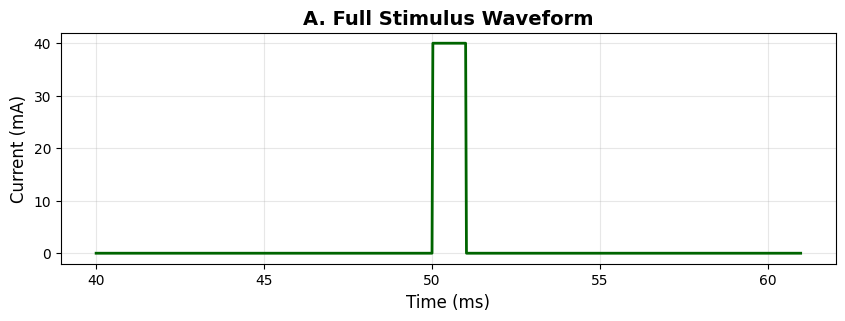

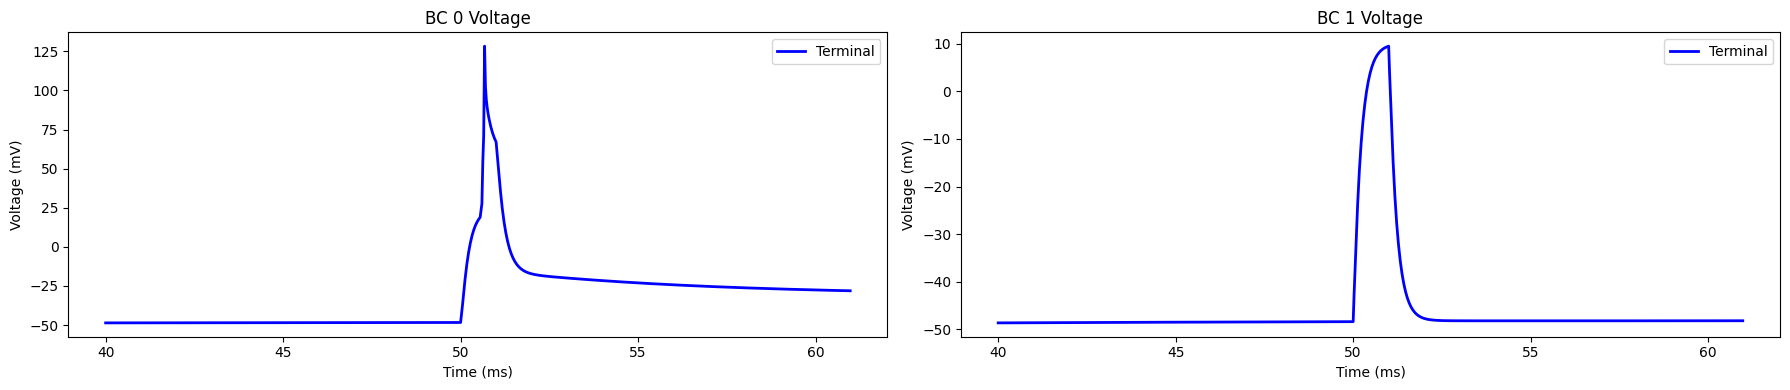

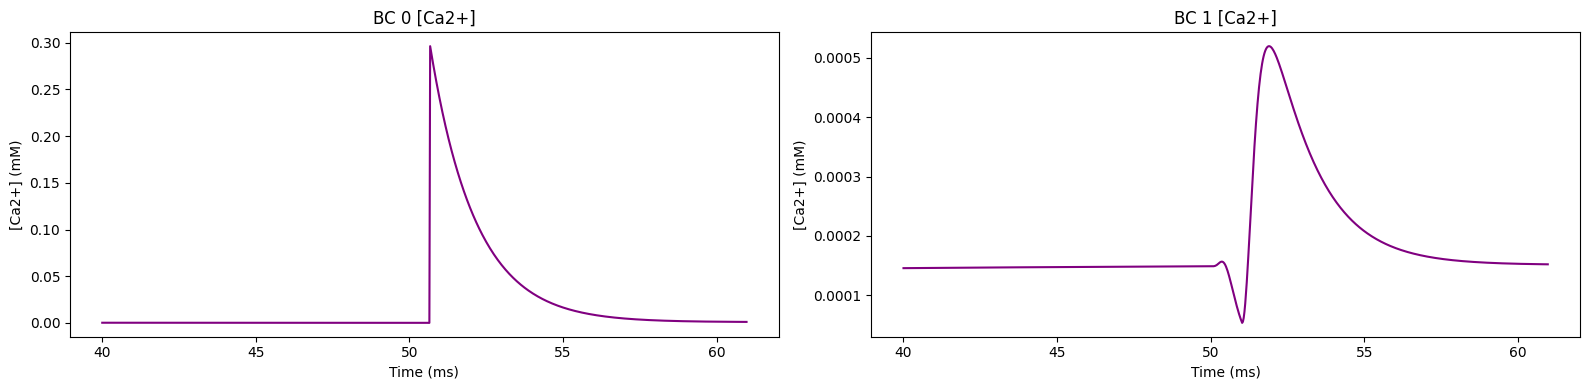

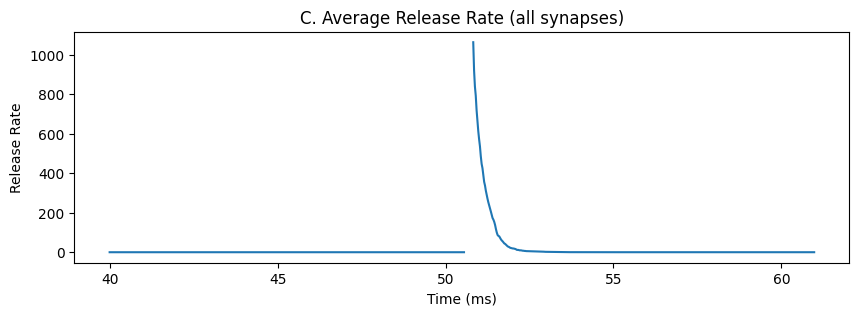

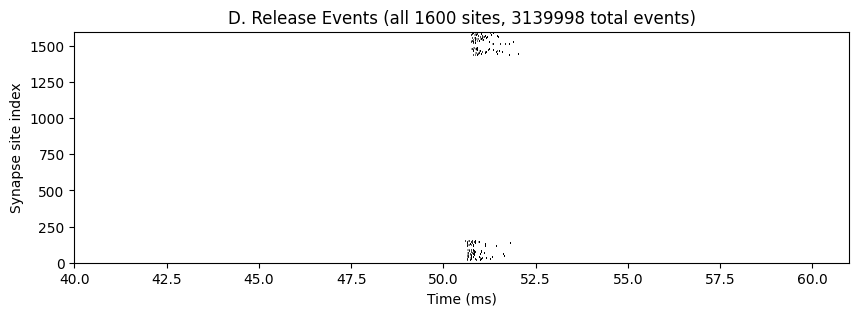

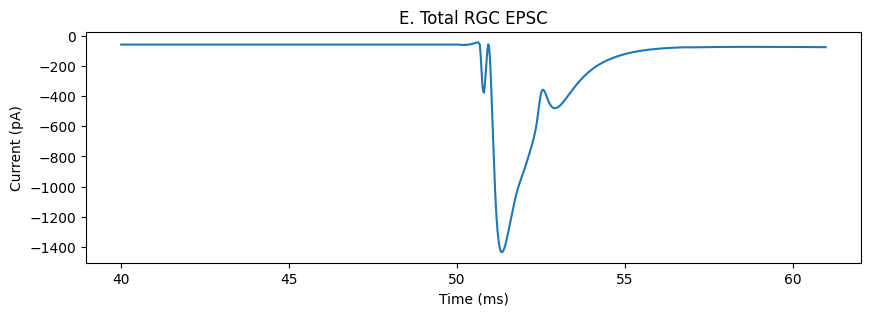

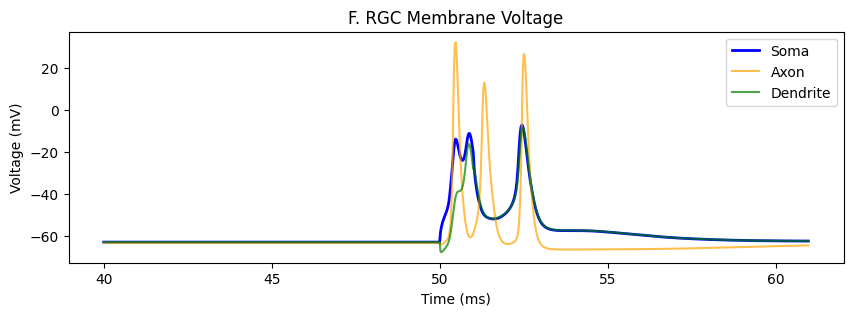

In [20]:
# tvalid should only be 10ms before and after stimulus
t_valid = (t >= (STIM_DELAY - 10)) & (t <= (STIM_DELAY + STIM_DUR + 10))
#t_valid = (t >= 0) & (t <= h.tstop)

# Plot 0: Stimulus Waveform
plt.figure(figsize=(10, 3))
stim_t = stim_time.as_numpy()
stim_amp = stim_trigger.as_numpy()
# Full timecourse
plt.plot(stim_t[t_valid], stim_amp[t_valid], linewidth=2, color='darkgreen')
plt.xlabel("Time (ms)", fontsize=12)
plt.ylabel("Current (mA)", fontsize=12)
plt.title("A. Full Stimulus Waveform", fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.show()


# Plot 1: Extracellular Potential at cells
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 4))

# BC 0     
ax1.plot(t[t_valid], v_pre_0[t_valid], color="blue", linewidth=2, label='Terminal')
ax1.set_title("BC 0 Voltage")
ax1.set_xlabel("Time (ms)")
ax1.set_ylabel("Voltage (mV)")
ax1.legend()

# BC 1     
ax2.plot(t[t_valid], v_pre_1[t_valid], color="blue", linewidth=2, label='Terminal')
ax2.set_title("BC 1 Voltage")
ax2.set_xlabel("Time (ms)")
ax2.set_ylabel("Voltage (mV)")
ax2.legend()
plt.tight_layout()
plt.show()


# B — Presynaptic Ca2+ (Both cells)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))

ax1.plot(t[t_valid], ca1_0[t_valid], color='purple')
ax1.set_title("BC 0 [Ca2+]")
ax1.set_xlabel("Time (ms)")
ax1.set_ylabel("[Ca2+] (mM)")

ax2.plot(t[t_valid], ca1_1[t_valid], color='purple')
ax2.set_title("BC 1 [Ca2+]")
ax2.set_xlabel("Time (ms)")
ax2.set_ylabel("[Ca2+] (mM)")

plt.tight_layout()
plt.show()

# C — Average Release Rate
plt.figure(figsize=(10, 3))
plt.plot(t[t_valid], avg_rate[t_valid])
plt.xlabel("Time (ms)")
plt.ylabel("Release Rate")
plt.title("C. Average Release Rate (all synapses)")
plt.show()

# D — Release Events (FIXED)
plt.figure(figsize=(10, 3))
n_sites = len(event_trains)
event_count = 0

for k in range(n_sites):
    event_times = event_trains[k]
    valid_events = event_times[(event_times >= STIM_DELAY - 10) & (event_times <= STIM_DELAY + STIM_DUR + 10) & np.isfinite(event_times)]
    
    if len(valid_events) > 0:
        plt.eventplot([valid_events], lineoffsets=k, linelengths=0.8, colors='black', linewidths=0.5)
        event_count += len(valid_events)

plt.xlim(STIM_DELAY - 10, STIM_DELAY + STIM_DUR + 10)
plt.ylim(-1, n_sites)
plt.xlabel("Time (ms)")
plt.ylabel("Synapse site index")
plt.title(f"D. Release Events (all {n_sites} sites, {event_count} total events)")
plt.show()

# E — Ganglion Cell EPSC
plt.figure(figsize=(10, 3))
plt.plot(t[t_valid], EPSC_pA[t_valid])
plt.xlabel("Time (ms)")
plt.ylabel("Current (pA)")
plt.title("E. Total RGC EPSC")
plt.show()

# F — Ganglion Cell Membrane Voltage
plt.figure(figsize=(10, 3))
plt.plot(t[t_valid], v_s[t_valid], label='Soma', color='blue', linewidth=2)
plt.plot(t[t_valid], v_axon[t_valid], label='Axon', color='orange', alpha=0.7)
plt.plot(t[t_valid], v_dend[t_valid], label='Dendrite', color='green', alpha=0.7)
plt.xlabel("Time (ms)")
plt.ylabel("Voltage (mV)")
plt.title("F. RGC Membrane Voltage")
plt.legend()
plt.show()

#### Spatial Electrical Field Visualization

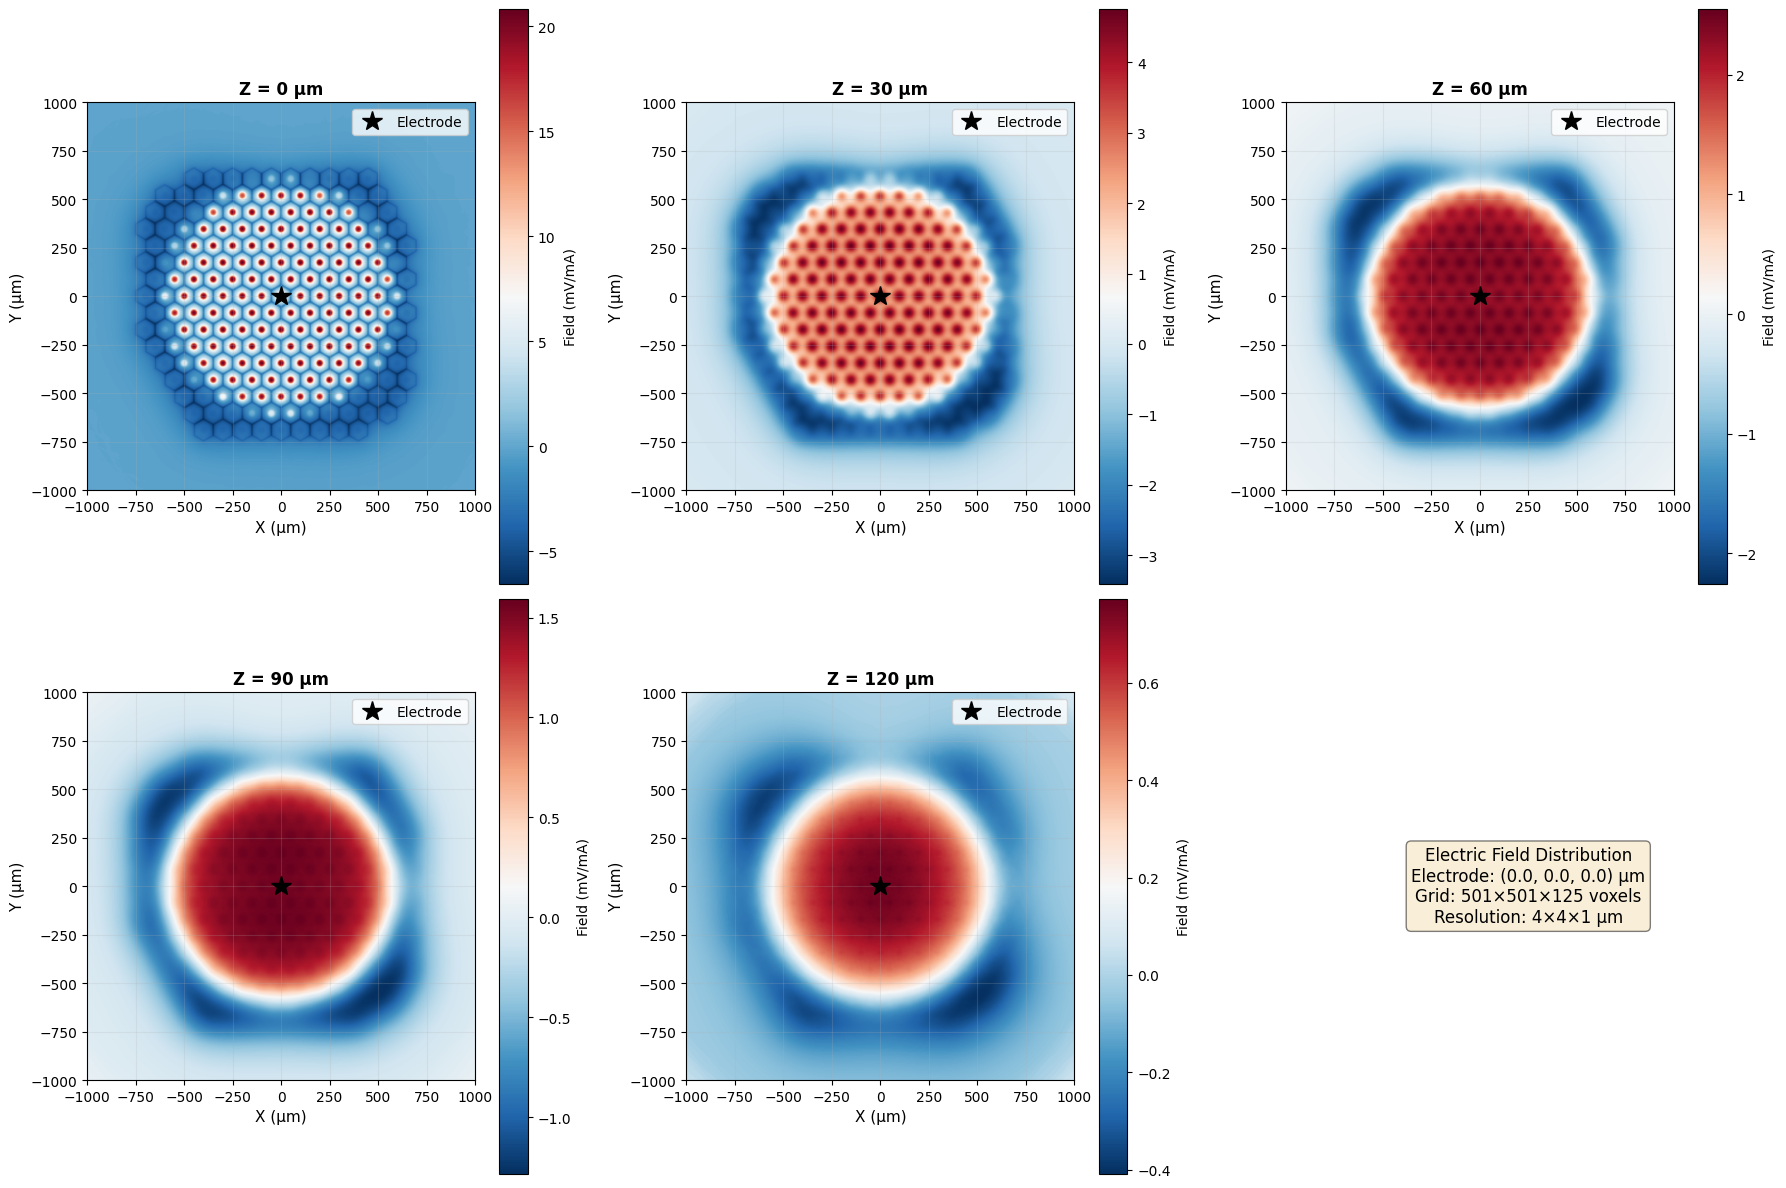

In [21]:
##### SPATIAL FIELD VISUALIZATION
plot_electric_field_slices(field_files_dir=f'{FIELD_DIR}/seq01_Spot1200_2Hz')